# Lab 7: K-Means Clustering 🗂

## Learning Objectives
* Calculate distance between points using Euclidean and Manhattan method
* Understand k-means clustering algorithm
* Visualize clusters
* Understand how to find appropriate k value from sum of squared errors

## Today's Lab

Today we will be taking our first look at clustering as a machine learning topic — specifically, [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering). K-means is an [unsupervised learning](https://en.wikipedia.org/wiki/Unsupervised_learning) method, which means that it doesn't need to have "true" labels or examples to learn a pattern. Instead, this class of algorithms can be described as pattern recognizers in the truest sense.

In this lab, we will first try our hand at implementing the algorithm, during which we will investigate how it works and explore some of the caveats to know when you use it. Then we will end by discussion how to choose the right number of clusters for your data.

By the end of the lab, you should have a pretty decent understanding of how $k$-means works.

## Outline

1. [Implementing K-means](#1.-Implementing-K-means)
2. [The Initial Centroids Matter!](#2.-The-Initial-Centroids-Matter!)
3. [Deciding How Many Clusters to Use](#3.-Deciding-How-Many-Clusters-to-Use)

## 1. Implementing K-means

### What is Clustering?

As usual, I'm just going to have Wikipedia do the honors of explaining what clustering is. Here is a quote from [Cluster Analysis](https://en.wikipedia.org/wiki/Cluster_analysis):

> Cluster analysis or clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters).

A common theme in our discussion of machine learning so far is the fact that we try to build models of the world that can describe specific phenomena. We want to be able to extract the patterns encoded by our observations (data) to study how a process works and potentially predict how that process might work in the future. In the case of $k$-means, we seek to systematically extract information about the distribution of our data by answering questions like "do our observations naturally form groups?"

![clustering](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Cluster-2.svg/220px-Cluster-2.svg.png)

Clustering, and especially $k$-means, is not just another algorithm, but can actually be a useful addition to any EDA process.

### Loading Our Toy Data

As usual, we will use some toy data to help us with our implementation. First, let's load the packages we will use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utility.util import configure_plots

configure_plots()

To help facilitate this process we have provided some toy data for you to use. In the cell we import the `load_toy` function, into which we can pass the number of points we would like to have $N$ and the number of clusters we would like to have $k$, among other values. This function will then return data points $X$ and another value that we don't really need to worry about now.

> **For the interested!** Feel free to check out how this data is generated.

In [2]:
from utility.util import load_toy

n, k = 300, 3
X, _ = load_toy(n, k, random_state=17)

Let's take a look at what we get.

**Try this!** In the cell below, produce a scatterplot of the data $X$. As a review, also be sure to add proper plot components.

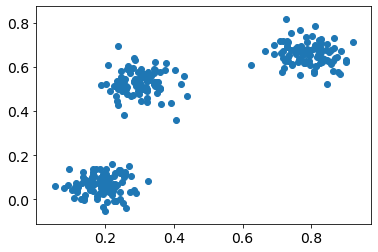

In [3]:
# your code here
plt.scatter(X[:,0],X[:,1] )

### Initializing Our Centroids

But wait what are centroids? In the $k$-means terminology, centroids are the centers of our clusters and will be what we use to determine to which cluster some point $x$ belongs.

While there are many ways to initialize our centroids, a _not-too-bad_ way to go about it is to randomly sample them from from our data. Later on, we will take a look at what you'll need to be aware of when choosing these points.

**Try this!** Complete the `sample_centroids` function so that it randomly samples and returns $k$ points from $X$ that we can use as our initial centroids. To make things easy, please return the centroids as a NumPy array with a structure similar to the $X$ matrix. _**Hint**: You can choose (sample) from an array using using [`np.random.choice` 🔗](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html)._

In [4]:
def sample_centroids(X, k, random_state=None):
    '''Sample and return K data points from X'''
    
    if random_state:
        np.random.seed(random_state)
    
    # your code here
    centroids= X[np.random.choice(X.shape[0], k)]
    
    assert isinstance(centroids, np.ndarray), 'Your centroids should be in a NumPy array'
    assert centroids.shape == (k, X.shape[1]), f'Your centroids should have shape ({k}, {X.shape[1]})'
    
    return centroids

In [5]:
centroids = sample_centroids(X, k, random_state=9)
centroids

array([[ 0.19492997, -0.03682865],
       [ 0.3198799 ,  0.49680163],
       [ 0.83111115,  0.62271631]])

Let's take a peek at which points where chosen.

**Try this!** In the cell below, recreate the scatter plot of $X$ you made earlier. Then scatter the centroids on top of it. Make sure that the centroids are obviously visible. `Hint` consider changing the size, marker, and color of the centroid points.

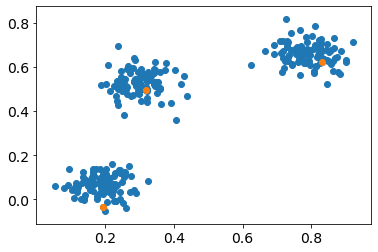

In [6]:
# your code here
plt.scatter(X[:,0], X[:,1])
plt.scatter(centroids[:,0], centroids[:,1])

### Similarity Measures

Now that we have centroids, the next thing will want to do is to be able to compute the similarity (or distances) between a group of points to a centroid. In this section, we will implement [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) and [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distances.

#### Euclidean Distance

I'm sure you are all familiar with this distance measure from life. Here is the formula: $$d(\pmb{p}, \pmb{q}) = \| \pmb{p} - \pmb{q} \| = \sqrt{\sum_{j=1}^{d} (p_j - q_j)^2}$$

**Try this!** Complete the `euclidean` function so that it computes the [Euclidean](https://en.wikipedia.org/wiki/Euclidean_distance) distance between point(s) `a` and point `b`. _**Hint**: Array `a` can be an array of points. You may use the [`ndim` 🔗](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.ndim.html) of a NumPy array to find its dimensionality._

In [7]:
def euclidean(a, b):
    '''Computes the Euclidean distance between point(s) A and another point B'''
    
    # your code here
    if np.ndim(a) > 1:
        distance = np.linalg.norm(a-b, axis = 1)
    else:
        distance = np.linalg.norm(a-b)

    assert isinstance(distance, (float, np.float64, np.ndarray)), 'Distance should be a float or a NumPy array'
    assert True if not isinstance(distance, np.ndarray) else distance.shape[0] == a.shape[0], \
        'Should have the same number of distances as points in A'
    
    return distance

Let's see if your computation was right. Work out the Euclidean distance between $(0, 0)$ and $(2, 2)$ and compare that value to what your function returns.

In [8]:
euclidean(np.zeros(2), np.array([2, 2]))

2.8284271247461903

#### Manhattan Distance

Here's an example of an alternative distance measure. Imagine that you are actually trying to drive between two places in a city like New York.

![manhattan](https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Manhattan_distance.svg/200px-Manhattan_distance.svg.png)

How far do you have to go?

**Try this!** Complete the `manhattan` function so that it computes the [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) distance between point(s) `a` and point `b`. `Hint` `a` can be an array of points.

In [9]:
def manhattan(a, b):
    '''Computes the Manhattan distance between point(s) A and another point B'''

    # your code here
    
    distance = np.sum((np.abs(a-b)))
    
    assert isinstance(distance, (float, np.float64, np.ndarray)), 'Distance should be a float or a NumPy array'
    assert True if not isinstance(distance, np.ndarray) else distance.shape[0] == a.shape[0], \
        'Should have the same number of distances as points in A'
    
    return distance

Check with your neighbors that your implementation works.

In [10]:
manhattan(np.zeros(2), np.array([2, 2]))

4.0

### Assigning Points to Clusters

Okay, we can now get back to what we wanted to do: cluster. In this section we will implement a function that can take a point $x$ or a matrix $X$ and assign it or them to the cluster of the closest centroid.

**Try this!** Complete the `assign` function so that it assigns each point to a cluster denoted by the index of the centroid. For example, if some point $x$ is closest to centroid $c_0$ then it should be assigned to cluster $0$. _**Hint**: One way to do this begins by creating an $n \times k$ array of zeros to store distance values from each oberservation in `x` to each centroid in `centroids`._

In [11]:
def assign(x, centroids, distance_measure=euclidean):
    '''
    Computes the cluster assignments for X or each point
    in X given some centroids and a distance measure
    '''
    
    # your code here
#     assignments = np.empty((x.shape[0], centroids.shape[0]))
#     for i in range(x.shape[0]): 
#         for j in range(centroids.shape[0]):
#             assignments[i][j] = (distance_measure(x[i], centroids[j]))
#     assignments = np.argmin(assignments)

    assignments = np.c_[[distance_measure(x, centroid) for centroid in centroids]].argmin(axis=0)
    
    assert np.all(assignments >= 0) and np.all(assignments < len(centroids)), \
        'Assignments should be indices of centroids'
    
    return assignments

In [12]:
assignments = assign(X, centroids, distance_measure=euclidean)

Now that we can compute the cluster assignments, let's plot and visualize them.

**Try this!** Recreate the same plot you made before with the data points and the centroids, but this time color the data points based on their assignments.

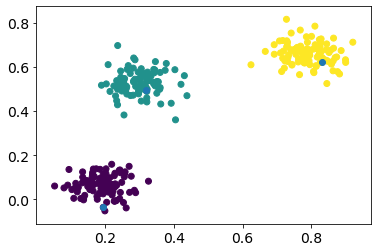

In [13]:
# your code here
plt.scatter(X[:,0], X[:,1], c=assignments)
plt.scatter(centroids[:,0], centroids[:,1])

### Updating Centroids

Now that we have some plausible assignments of our data points into clusters centered on the centroids, we can think about how we might improve the centroids. In the $k$-means algorithm, we compute new centroids by averaging the positions of all data points assigned to a cluster. This average point describes a "central" location within each cluster and thus makes sense as a representative for each cluster.

**Try this!** Complete the `compute_centroids` function so that it computes a new centroid for each cluster given the points assigned to each cluster by averaging those points. _**Hint**: Consider using `np.unique` to find all possible assignment values._

In [14]:
def compute_centroids(X, assignments):
    '''Computes new centroids given points X and cluster ASSIGNMENTS'''
    
    # your code here
    centroids = np.array([X[assignments == cluster].mean(axis=0)                 
    for cluster in np.unique(assignments)])
    
    
    assert len(np.unique(assignments)) == len(centroids), \
        'You should have the same number of centroids as clusters'
    
    return centroids

Let's check that it works.

In [15]:
old_centroids = centroids
centroids = compute_centroids(X, assignments)
centroids

array([[0.1899978 , 0.06404952],
       [0.3028982 , 0.52839256],
       [0.79155857, 0.66059625]])

With that, we have all of the components of the $k$-means algorithm. Let's write a function that can plot all of thes things.

**Try this!** Complete the `plot_kmeans` function so that it recreates the last plot that you made earlier, but this time, it can **optionally** scatter the `old_centroids` in a different color. `Hint` Check if an arg is `None`.

In [16]:
def plot_kmeans(X, centroids, prev_centroids=None, assignments=None):
    '''
    Creates k-means plots
    '''
       
    plt.scatter(X[:,0], X[:,1])
    plt.scatter(centroids[:,0], centroids[:,1])
    if prev_centroids is not None:
        plt.scatter(prev_centroids[:,0], prev_centroids[:,1])
    
    # your code here


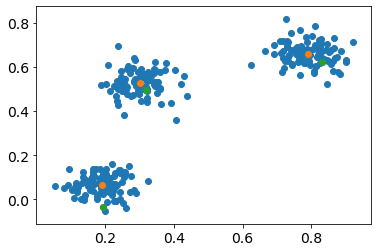

In [17]:
plot_kmeans(X, centroids, prev_centroids=old_centroids, assignments=assignments)

### Putting Things Together

With the last section, we finished all of the components that we need to construct the $k$-means algorithm. As you might have noticed, by repeating the assignment-cluster-mean cycle, we can get more and more central centroids. As we iterate

**Try this!** Complete the `fit` function, which should return the final centroids. Ensure that you make use of all of the supplied function arguments. If `initial=None` then you should generate some random centroids.

In [18]:
def fit(X, k, max_iters=1000, tol=1e-2, initial=None, random_state=None):
    '''
    Runs k-means cycle with data X and K clusters until either MAX_ITERS
    number of iterations have been performed or until the absolute centroid delta
    is less than TOL.
    '''
    
    if initial is None:
        centroids = sample_centroids(X, k, random_state=random_state)
    else:
        centroids = initial
    
    assert k == centroids.shape[0], \
        f'expected there to be {k} centroids but got {centroids.shape[0]}'
    
    # your code here
    for it in range(max_iters):
        assignments = assign(X, centroids)    
        prev, centroids = centroids, compute_centroids(X, assignments)      
        if np.all(np.abs(prev - centroids) < tol):            
            break
            
    return centroids

Let's try it out.

[[0.40989028 0.67157138]
 [0.11963086 0.59248767]
 [0.82547567 0.04411385]
 [0.91176561 0.36013557]
 [0.85998214 0.7853962 ]
 [0.88290168 0.85675474]
 [0.649096   0.99132489]
 [0.86992933 0.28936968]
 [0.80868598 0.42279709]
 [0.53005363 0.47408821]]


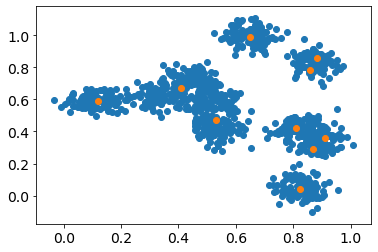

In [24]:
centroids = fit(X, k)
print(centroids)
assignments = assign(X, centroids)

plot_kmeans(X, centroids, assignments=assignments)

**Try this!** If you have a chance, before you move on, try using a different distance measure and see what happens.

## 2. The Initial Centroids Matter!

The $k$-means algorithm is sensitive to the initial starting points. In this section, let's explore this.

In the cell below, we generate a new data toy dataset with more clusters in order to make things more obvious.

In [20]:
n, k = 500, 5
X, _ = load_toy(n, k, random_state=10)

**Try this!** Using the functions `sample_centroids`, `fit`, and `plot_kmeans`, experiment with different `random_state`s to see if you can observe different final centroids depending on the initial starting points.

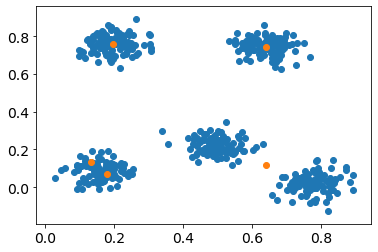

In [21]:
# your code here
centroids = fit(X, k)
assignments = assign(X, centroids)

plot_kmeans(X, centroids, assignments=assignments)

**Write-up!** Why might be causing this to happen? How might we better choose our initial centroids? Discuss your answer with your neighbors.

## 3. Deciding How Many Clusters to Use

As we have seen for $k$-means, $k$ is the number of clusters/centroids that the algorithm will try to find. Choosing $k$ is an important task as it determines the output of the algorithm. Since $k$ is a model parameter, we can try to use some good-ol' model selection to do this.

Consider the Sum of Squared Distances $SSD_j$ as the sum of all points in the $j$th cluster to its corresponsing cluster center $c_j$: 
$$SSD_j = \sum_{i=1}^{n} z_{ij} \;d(x_i,c_j),$$
where $z_{ij}$ is 1 if $x_i$ belongs to cluster $j$ and 0 otherwise. 

Then, the objective function that $k$-means optimizes is the sum of the $SSD_j$ over all clusters. This means that, we want to find clusters of points that are close to one another. We can estimate how close the cluster points are to one another by measuring how far each point assigned to the cluster is from its center.

In the cell below, we will generate a dataset with a random number of clusters.

In [22]:
n, k = 1000, np.random.randint(1, 11)
X, y = load_toy(n, k, random_state=6)

**Try this!** In the following cell, `fit` multiple $k$-means centroids with $k \in [1, 10]$, compute the sum of the $RSS_k$ for each cluster, and plot these values across $k$.

In [23]:
# your code here
ks = np.arange(1,11)
scores = []
for k in ks:    
    centroids = fit(X, k)
    assignments = assign(X, centroids)
    ssd = np.concatenate([euclidean(X[assignments == cluster], centroids[cluster]) 
for cluster in np.unique(assignments)]).sum()
    scores.append(ssd)    
plt.plot(ks, scores)
plt.title('K-means Elbow')
plt.xlabel('k')
plt.ylabel('Sum SSD_k')




ValueError: operands could not be broadcast together with shapes (10,2) (9,2) 

**Write-up!** Describe how you would choose which $k$ to use. Then, choose the $k$ you would use going forward (if you had to).

## 4. [Optional] Trying K-means On A Not-So-Simple Dataset

**Try this!** Let's try using $k$-means on a different dataset. In the cell below, we prepare $X$ for you. Cluster the data and visualize the results. Use a `random_state` of 7.

In [ ]:
from sklearn.datasets import make_moons

X, _ = make_moons(500, noise=0.1)

# your code here


**Write-up!** What do you notice about the clustering results from $k$-means? What are the implications of these results? Write your answers below and discuss them with your neighbors.